In [1]:
import scanpy as sc
import matplotlib.pyplot as pl
import seaborn as sns
import pandas as pd
import numpy as np
import sys
import scvelo as scv
from pathlib import Path

# Paths and utils
root = Path('../')
figure_path = root / 'results/figures/Neutrophils/'
figure_path.mkdir(parents=True, exist_ok=True)
table_path = root / 'results/tables/'
signatures_path = root / 'resources/'
import yaml
with open('../config/config.yaml', 'r') as file:
    config = yaml.safe_load(file)
data_path = config['data_path']
# local utils
sys.path.insert(1, '../utils/')
from utils import plot_differential_test

# Set plotting style
from matplotlib import rcParams
# Type 2/TrueType fonts
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
# Arial font
rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "sans-serif"
%matplotlib inline

# Load data

In [2]:
superdata = sc.read(data_path / "Pancov19_prepd_all.h5")

# Import color options
import yaml
with open('../config/config.yaml', 'r') as file:
    config = yaml.safe_load(file)
celltype_colors = config['celltype_colors']
celltype_rough_colors = config['celltype_rough_colors']
organism_colors = config['organism_colors']
organism_dosage_colors = config['organism_dosage_colors']
dosage_colors = config['dosage_colors']

# Newer names, more accurate
organism_rename_dict = {
    'Dwarfhamster': 'Roborovski hamster',
    'Goldhamster': 'Syrian hamster'
}
time_rename_dict = {
    'D0': '0 dpi',
    'D2': '2 dpi',
    'D3': '3 dpi',
    'D5': '5 dpi',
    'E14': '14 dpi'
}
dosage_rename_dict = {
    'no dose': '0 pfu',
    'low dose': r'$1\times10^4$ pfu',
    'high dose': r'$1\times10^5$ pfu'
}

def sanitize_name(s):
    for rdict in [organism_rename_dict, time_rename_dict, dosage_rename_dict]:
        for old, new in rdict.items():
            s = s.replace(old, new)
            
    return s.replace('_', ', ')

from matplotlib.cm import get_cmap
# not super pretty, but ok for now
time_colors = {
    'D0': 'grey',
    'D2': get_cmap('viridis_r')(0),
    'D3': get_cmap('viridis_r')(1/3),
    'D5': get_cmap('viridis_r')(2/3),
    'E14': get_cmap('viridis_r')(1),
              }
    
# Translate color palettes to new names as well
Organism_colors = {sanitize_name(key) : value for key, value in config['organism_colors'].items()}
Organism_Dosage_colors = {sanitize_name(key) : value for key, value in config['organism_dosage_colors'].items()}
Dosage_colors = {sanitize_name(key) : value for key, value in config['dosage_colors'].items()}
Time_colors = {sanitize_name(key) : value for key, value in time_colors.items()}

# define control dicts for DE testing etc.
control_dict = {x: ['pr_D0_Z1_L','pr_D0_Z2_L','pr_D0_Z3_L'] if 'pr' in x else ['ma_d0_lung_1', 'ma_d0_lung_2', 'ma_d0_lung_3'] for x in pd.unique(superdata.obs['orig.ident']) if '0' not in x}
control_dict_odt = {x: 'Dwarfhamster_no dose_D0' if 'Dwarfhamster' in x else 'Goldhamster_no dose_D0' for x in superdata.obs.organism_dosage_time.unique() if 'D0' not in x}

# UMAPs for many markers parallel for organism_dosages

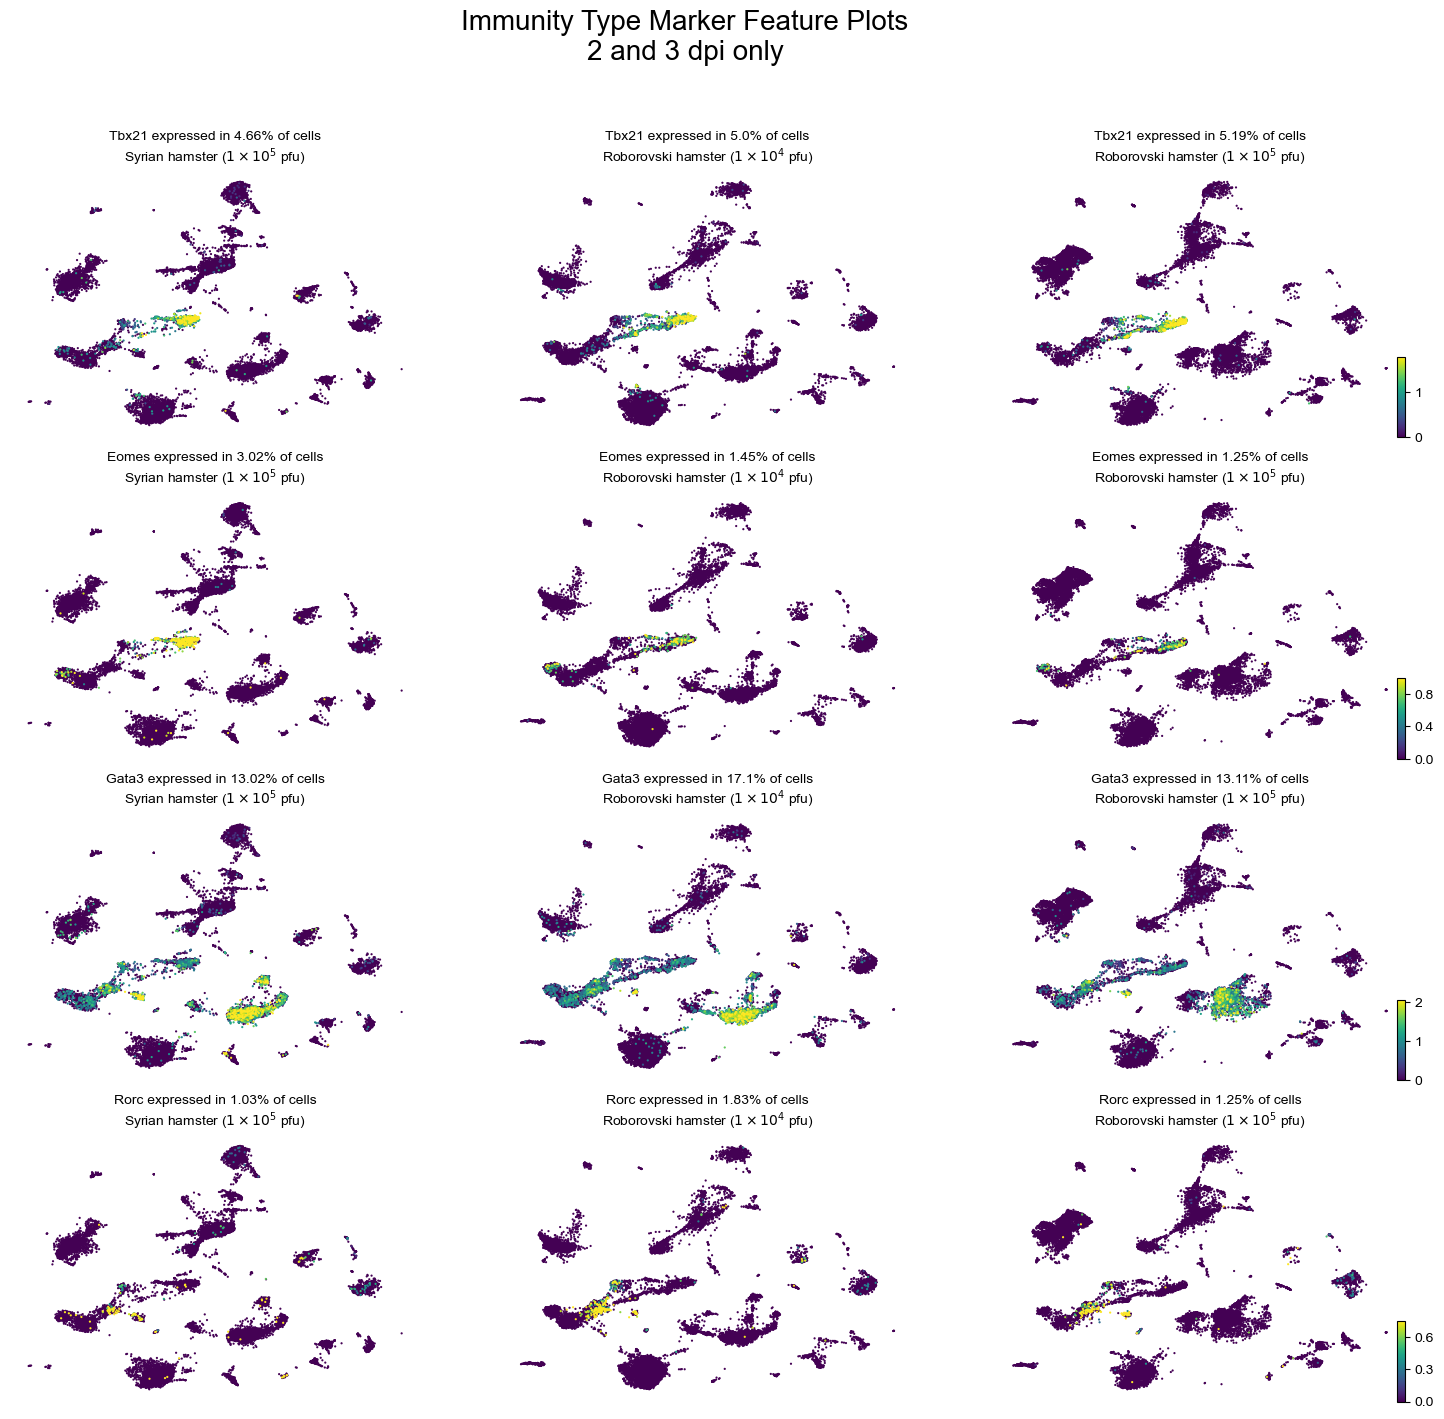

In [13]:
keys = ['Tbx21', 'Eomes', 'Gata3', 'Rorc']
N = len(keys)
fig, axss = pl.subplots(N, 3, figsize=(6*3, 4*N))
kwargs = dict(dpi=80, legend_loc='right margin', show=False, s=10)  # perc=[0.5,99.5], 

for key, axs in zip(keys, axss):
    vmax = np.percentile(superdata[superdata.obs.time.isin(['D2', 'D3']), key].X.A, 99.5)
    for ax, organism, dosage in zip(axs, ['Goldhamster', 'Dwarfhamster', 'Dwarfhamster'], ['high dose', 'low dose', 'high dose']):
        mask = (superdata.obs.organism==organism) & (superdata.obs.dosage.isin(['no dose', dosage])) & (superdata.obs.time.isin(['D2', 'D3']))
        perc_exp = np.sum(superdata[mask, key].X!=0) / np.sum(mask)
        scv.pl.scatter(superdata[mask], 
                       basis='umap_scVI',
                       color=key, ax=ax, 
                       title=f'{key} expressed in {np.round(perc_exp*100,2)}% of cells\n{sanitize_name(organism)} ({sanitize_name(dosage)})',
                       vmin=0, vmax=vmax,
                       colorbar=ax==axs[-1],
                       **kwargs)
pl.suptitle('Immunity Type Marker Feature Plots\n2 and 3 dpi only', fontsize=20)
pl.savefig(figure_path / 'Fig3_selected_Immunity_umaps.pdf', bbox_inches='tight', dpi=300)
pl.savefig(figure_path / 'Fig3_selected_Immunity_umaps.png', bbox_inches='tight', dpi=300)
pl.show()

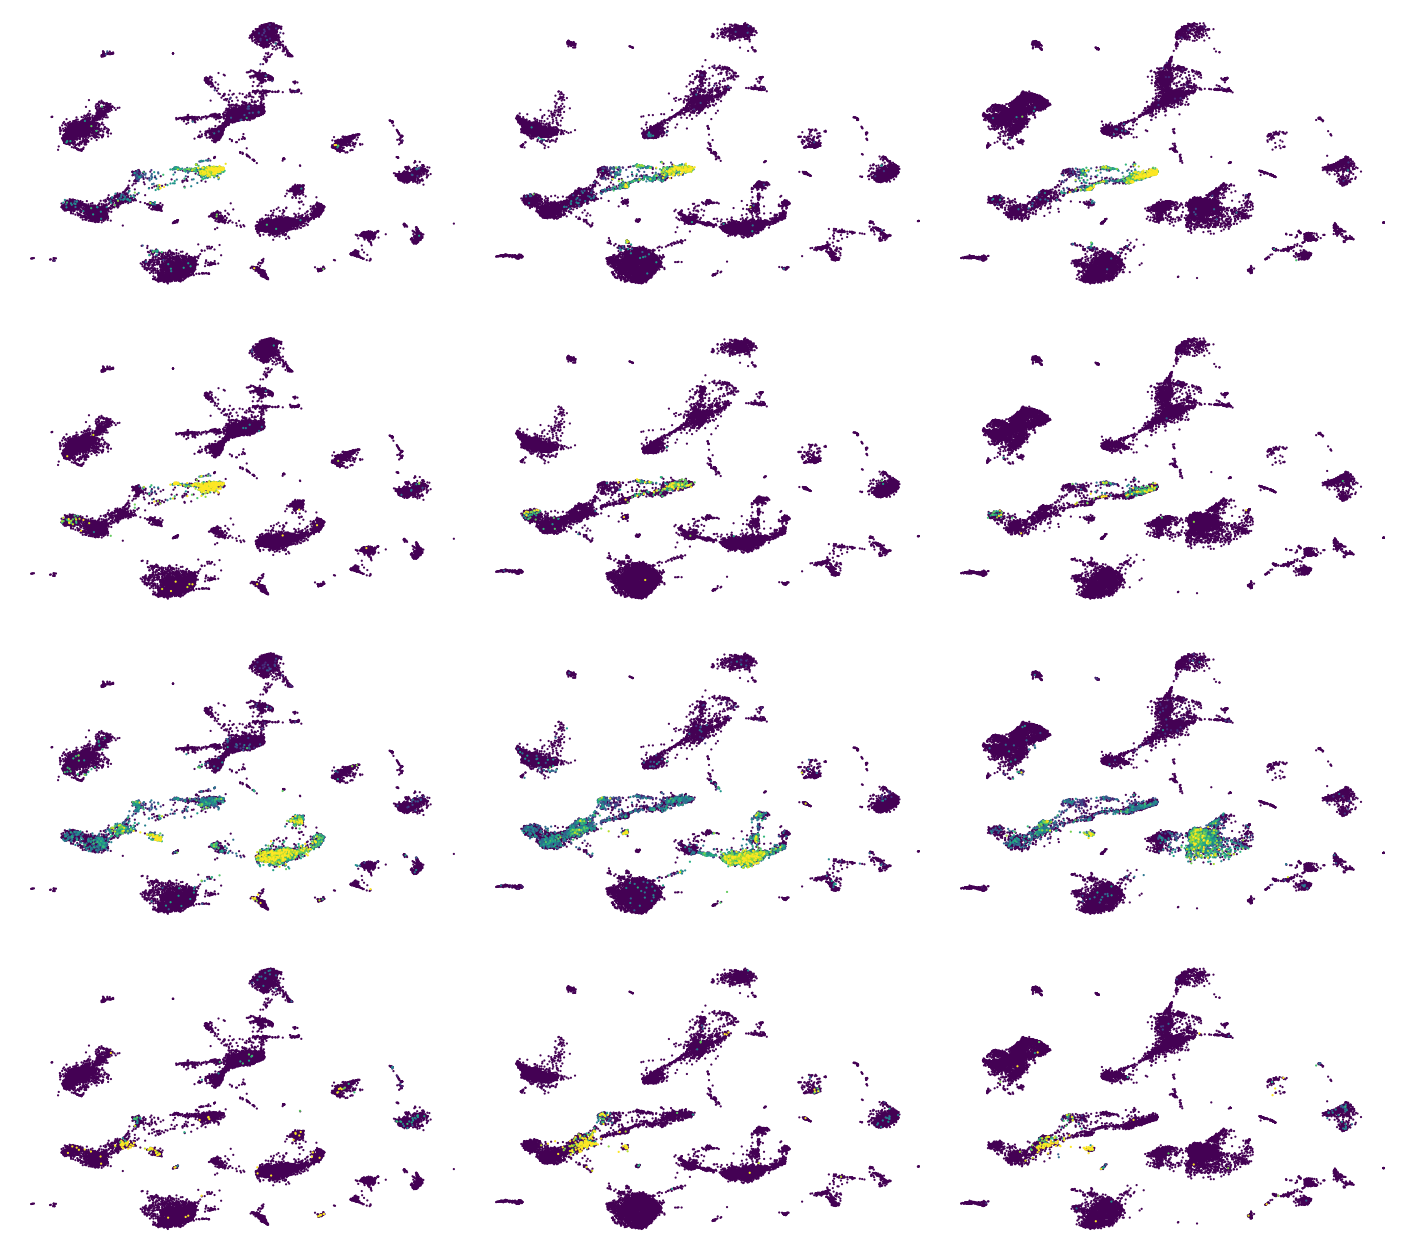

In [8]:
# single big png
keys = ['Tbx21', 'Eomes', 'Gata3', 'Rorc']
N = len(keys)
fig, axss = pl.subplots(N, 3, figsize=(6*3, 4*N), gridspec_kw=dict(wspace=0, hspace=0.1))
kwargs = dict(dpi=80, legend_loc='right margin', show=False, s=10)  # perc=[0.5,99.5], 

for key, axs in zip(keys, axss):
    vmax = np.percentile(superdata[superdata.obs.time.isin(['D2', 'D3']), key].X.A, 99.5)
    for ax, organism, dosage in zip(axs, ['Goldhamster', 'Dwarfhamster', 'Dwarfhamster'], ['high dose', 'low dose', 'high dose']):
        mask = (superdata.obs.organism==organism) & (superdata.obs.dosage.isin(['no dose', dosage])) & (superdata.obs.time.isin(['D2', 'D3']))
        perc_exp = np.sum(superdata[mask, key].X!=0) / np.sum(mask)
        scv.pl.scatter(superdata[mask], 
                       basis='umap_scVI',
                       color=key, ax=ax, 
                       title='',
                       vmin=0, vmax=vmax,
                       colorbar=False,
                       **kwargs)
pl.savefig(figure_path / 'Fig3_selected_Immunity_notext_umaps.png', bbox_inches='tight', dpi=300)
pl.show()

In [4]:
# save colorbars separately
keys = ['Tbx21', 'Eomes', 'Gata3', 'Rorc']
kwargs = dict(dpi=80, legend_loc='right margin', show=False, s=10)  # perc=[0.5,99.5], 
for key in keys:
    vmax = np.percentile(superdata[superdata.obs.time.isin(['D2', 'D3']), key].X.A, 99.5)
    for organism, dosage in zip(['Goldhamster', 'Dwarfhamster', 'Dwarfhamster'], ['high dose', 'low dose', 'high dose']):
        mask = (superdata.obs.organism==organism) & (superdata.obs.dosage.isin(['no dose', dosage])) & (superdata.obs.time.isin(['D2', 'D3']))
        perc_exp = np.sum(superdata[mask, key].X!=0) / np.sum(mask)
        fig, ax = pl.subplots(figsize=(6, 4))
        scv.pl.scatter(superdata[mask], 
                       basis='umap_scVI',
                       color=key, 
                       ax=ax, 
                       title='',
                       vmin=0, vmax=vmax,
                       colorbar=True,
                       **kwargs)
        ax.remove()
        pl.savefig(figure_path / f'colorbar_for_umap_{key}.pdf', bbox_inches='tight')
        pl.close()
        break

# L2FC of Immunity Markers

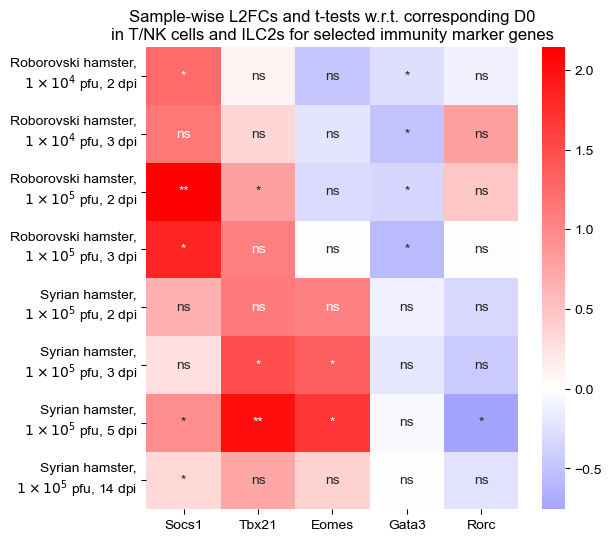

In [41]:
mask = superdata.obs.celltype_rough.isin(['T cells', 'NK cells', 'ILC2'])
genes = ['Tbx21', 'Gata3', 'Rorc', 'Eomes', 'Socs1']
fig, ax = pl.subplots(figsize=[6,6])
plot_differential_test(superdata[mask].copy(), genes, 'organism_dosage_time', ax=ax,
                       show=False, control=control_dict_odt, replicate_key='orig.ident', cluster='col')
ax.set_title('Sample-wise L2FCs and t-tests w.r.t. corresponding D0\nin T/NK cells and ILC2s for selected immunity marker genes')
yticklabels = [sanitize_name(y.get_text()).replace('ster,', 'ster,\n') for y in ax.get_yticklabels()]
ax.set_yticklabels(yticklabels)
pl.savefig(figure_path / 'ILC2_T_and_NKcells_immunitymarkers_l2fcs.pdf', bbox_inches='tight', dpi=300)
pl.show()

In [10]:
# Export table for Fig3B
pval_adj_tab, l2fc_tab, fc_tab = differential_test(
    superdata[mask].copy(), genes, 'organism_dosage_time', 
    control=control_dict_odt, replicate_key='orig.ident')
writer = pd.ExcelWriter(table_path / 'Fig3B_source.xlsx', engine='xlsxwriter')
pval_adj_tab.to_excel(writer, sheet_name='Adjusted p-values')
l2fc_tab.to_excel(writer, sheet_name='L2FCs')
fc_tab.to_excel(writer, sheet_name='FCs')
writer.save()

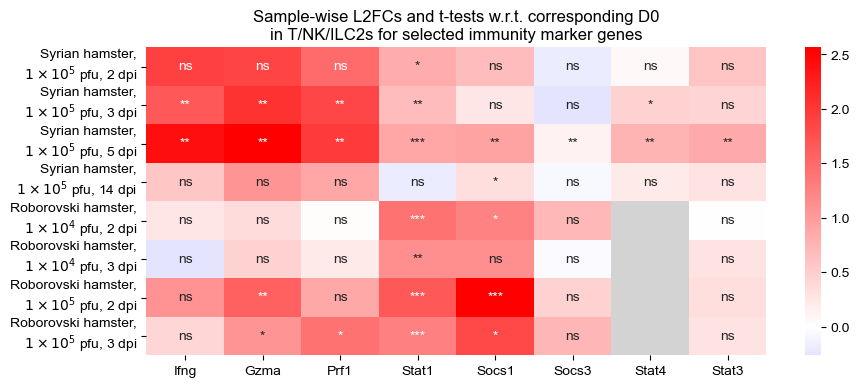

In [6]:
row_order = [
    'Goldhamster_high dose_D2',
    'Goldhamster_high dose_D3',
    'Goldhamster_high dose_D5',
    'Goldhamster_high dose_E14',
    'Dwarfhamster_low dose_D2',
    'Dwarfhamster_low dose_D3',
    'Dwarfhamster_high dose_D2',
    'Dwarfhamster_high dose_D3',
 ]

mask = superdata.obs.celltype_rough.isin(['T cells', 'NK cells', 'ILC2'])
genes = ['Stat4', 'Stat1', 'Stat3', 
         'Gzma', 'Prf1', 'Ifng', 'Socs1', 'Socs3']
fig, ax = pl.subplots(figsize=[10,4])
plot_differential_test(superdata[mask].copy(), genes, 'organism_dosage_time', 
                        ax=ax, row_order=row_order,
                       show=False, control=control_dict_odt, 
                       replicate_key='orig.ident', cluster='col')
ax.set_title('Sample-wise L2FCs and t-tests w.r.t. corresponding D0\nin T/NK/ILC2s for selected immunity marker genes')
yticklabels = [sanitize_name(y.get_text()).replace('ster,', 'ster,\n') for y in ax.get_yticklabels()]
ax.set_yticklabels(yticklabels)
pl.savefig(figure_path / 'Supp_ILC2_T_and_NKcells_immunitymarkers_l2fcs.pdf', bbox_inches='tight', dpi=300)
pl.show()

# Time courses

In [3]:
cm = 1/2.54  # centimeters in inches
def plot_timecourse_dose(adata, key, x='time', ci=99, markers=True, linewidth=2, **kwargs):
    keys = [key] if type(key)==str else key
    N = len(keys)
    #with sns.axes_style('white'):
    fig, axs = pl.subplots(1,N, figsize=[17.5 / 4 * cm * N, 3 * cm], dpi=150)
    axs = [axs] if N==1 else axs
    for key, ax in zip(keys, axs):
        df = extract_df(adata, [key, x, 'organism', 'dosage', 'organism_dosage'])
        df_ = df[df.organism_dosage=='Dwarfhamster_no dose']
        df = df[df.organism_dosage!='Dwarfhamster_no dose']
        df_['organism_dosage'] = 'Dwarfhamster_low dose'
        df = pd.concat([df, df_])
        df_['organism_dosage'] = 'Dwarfhamster_high dose'
        df = pd.concat([df, df_])
        df.organism_dosage[df.organism_dosage.isin(['Goldhamster_no dose', 'Goldhamster_high dose'])] = 'Goldhamster'
        df.index = np.sum(np.vstack([df.index, np.arange(len(df)).astype(str)]), axis=0)
        
        sns.lineplot(data=df, y=key, x=x, hue='organism_dosage', ci=ci, markers=markers, linewidth=linewidth, ax=ax, **kwargs)
        ax.set_title(key, fontsize=6, pad=4)
        ax.locator_params(axis='y', nbins=6)
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.set_yticklabels(ax.get_yticklabels(), fontsize=5)
        ax.set_xticklabels(['naive', '2', '3', '5', '14'], fontsize=5)
        ax.tick_params(axis='both', which='major', pad=1, length=2, width=0.5)
        [x.set_linewidth(0.25) for x in ax.spines.values()]
    axs[0].set_ylabel('Gene Expression', fontsize=5)
    return axs

palette = {'Goldhamster': organism_colors['Goldhamster'],
           'Dwarfhamster_low dose': organism_dosage_colors['Dwarfhamster_low dose'],
           'Dwarfhamster_high dose': organism_dosage_colors['Dwarfhamster_high dose'],
}

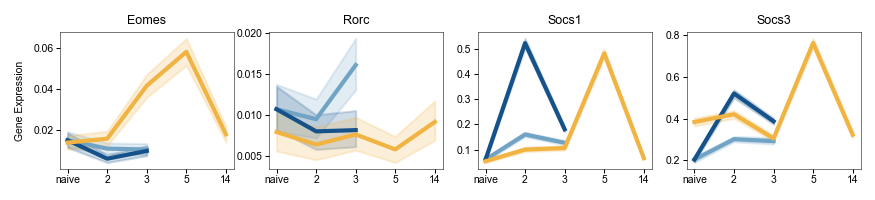

In [88]:
axs = plot_timecourse_dose(superdata, ['Eomes', 'Rorc', 'Socs1', 'Socs3'], x='time', 
                     ci=99, markers=True, linewidth=2, palette=palette)

for ax in axs:
    ax.get_legend().remove()

pl.savefig(figure_path / 'Fig3C_immunity_timecourses_upper_row.pdf', bbox_inches='tight', dpi=300)
pl.show()

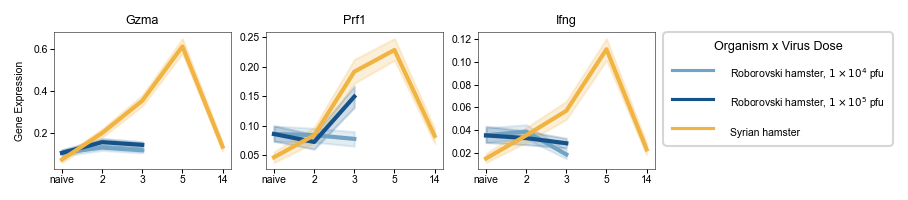

In [89]:
axs = plot_timecourse_dose(superdata, ['Gzma', 'Prf1', 'Ifng'], x='time', 
                     ci=99, markers=True, linewidth=2, palette=palette)
# clean up legend
ax = axs[-1]
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
texts = ax.legend_.get_texts()
for text in texts:
    text.set_text(sanitize_name(text.get_text()))
    text.set_fontsize(5)
ax.legend_.set_title('Organism x Virus Dose')
ax.legend_.get_title().set_fontsize('6')

# remove legend from all but last plot
for ax in axs[:-1]:
    ax.get_legend().remove()

pl.savefig(figure_path / 'Fig3C_immunity_timecourses_lower_row.pdf', bbox_inches='tight', dpi=300)
pl.show()

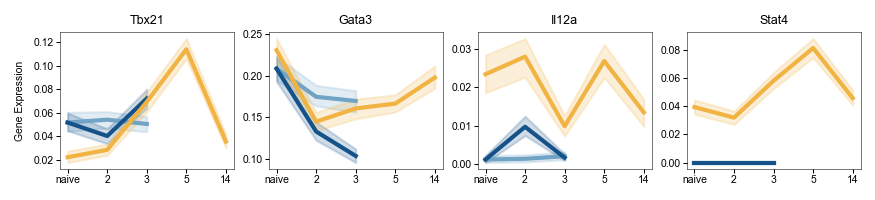

In [90]:
axs = plot_timecourse_dose(superdata, ['Tbx21', 'Gata3', 'Il12a', 'Stat4'], x='time', 
                     ci=99, markers=True, linewidth=2, palette=palette)

for ax in axs:
    ax.get_legend().remove()

pl.savefig(figure_path / 'SuppFig3A_immunity_timecourses_upper_row.pdf', bbox_inches='tight', dpi=300)
pl.show()

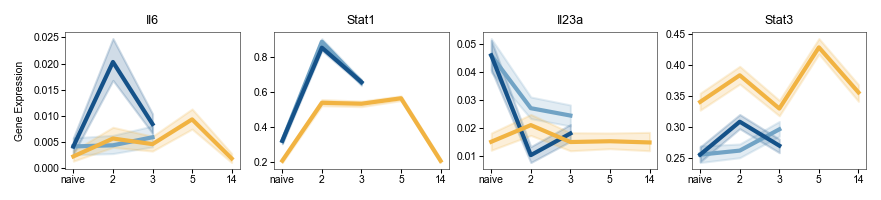

In [91]:
axs = plot_timecourse_dose(superdata, ['Il6', 'Stat1', 'Il23a', 'Stat3'], x='time', 
                     ci=99, markers=True, linewidth=2, palette=palette)

for ax in axs:
    ax.get_legend().remove()

pl.savefig(figure_path / 'SuppFig3A_immunity_timecourses_lower_row.pdf', bbox_inches='tight', dpi=300)
pl.show()

# Improved Time courses

In [8]:
cm = 1/2.54  # centimeters in inches
def plot_timecourse_dose_samples(adata, key, ci=99, markers=True, linewidth=2, **kwargs):
    keys = [key] if type(key)==str else key
    N = len(keys)
    #with sns.axes_style('white'):
    fig, axs = pl.subplots(1, N, figsize=[4 * N, 3 ], dpi=150)
    axs = [axs] if N==1 else axs
    for key, ax in zip(keys, axs):
        df = extract_df(adata, [key, 'time', 'organism', 'dosage', 'organism_dosage', 'orig.ident'])
        # aggregate and mean by sample
        sdf = df.groupby(['orig.ident', 'time', 'organism_dosage']).mean().dropna().reset_index()
        # use same D0 for all doses in lineplot
        adf = sdf.copy()
        adf.organism_dosage = adf.organism_dosage.astype(str)
        adf['organism_dosage'][adf.organism_dosage=='Goldhamster_no dose'] = 'Goldhamster_high dose'
        ldf = adf[adf.organism_dosage=='Dwarfhamster_no dose']
        ldf['organism_dosage'] = 'Dwarfhamster_low dose'
        adf['organism_dosage'][adf.organism_dosage=='Dwarfhamster_no dose'] = 'Dwarfhamster_high dose'
        adf = pd.concat([adf, ldf]).reset_index()
        sns.lineplot(data=adf, y=key, x='time', hue='organism_dosage', 
                     palette=organism_dosage_colors, ci=ci, markers=markers, 
                     linewidth=linewidth, ax=ax, **kwargs)
        sns.swarmplot(data=sdf.reset_index(), y=key, x=sdf.time, hue='organism_dosage', dodge=False, palette=organism_dosage_colors, ax=ax)
        
        ax.set_title(key, fontsize=6, pad=4)
        ax.locator_params(axis='y', nbins=6)
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.set_yticklabels(ax.get_yticklabels(), fontsize=5)
        ax.set_xticklabels(['naive', '2', '3', '5', '14'], fontsize=5)
        ax.tick_params(axis='both', which='major', pad=1, length=2, width=0.5)
        [x.set_linewidth(0.25) for x in ax.spines.values()]
        if ax==axs[-1]: 
            sns.move_legend(ax, 'lower left', bbox_to_anchor=(1.05, 0.05), frameon=False)
        else:
            ax.get_legend().remove()
    axs[0].set_ylabel('Gene Expression', fontsize=5)
    return axs


In [9]:
mask = superdata.obs.celltype_rough.isin(['T cells', 'NK cells', 'ILC2'])
markers = ['Tbx21', 'Gata3', 'Il12a', 'Stat4', 'Il6', 'Stat1', 'Il23a', 'Stat3', 'Gzma', 'Prf1', 'Ifng', 'Eomes', 'Rorc', 'Socs1', 'Socs3']

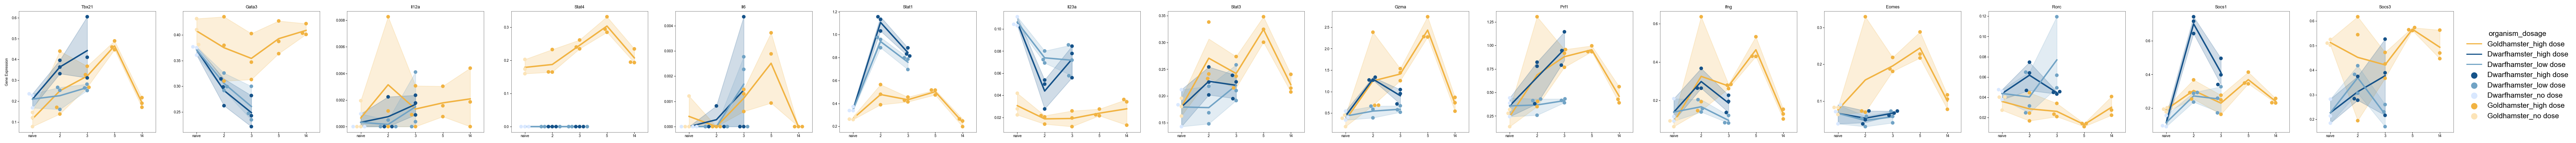

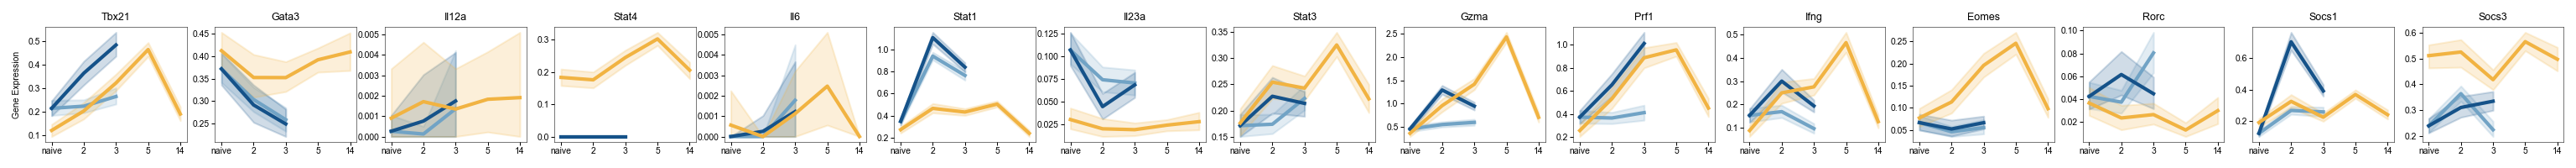

In [12]:
axs = plot_timecourse_dose_samples(superdata[mask], markers, ci=95)
pl.savefig('Timecourse_TNKILC2only_samplewise.pdf', bbox_inches='tight', dpi=300)
axs = plot_timecourse_dose(superdata[mask], markers, ci=99, markers=True, linewidth=2, palette=palette)
for ax in axs:
    ax.get_legend().remove()
pl.savefig('Timecourse_TNKILC2only_cellwise.pdf', bbox_inches='tight', dpi=300)


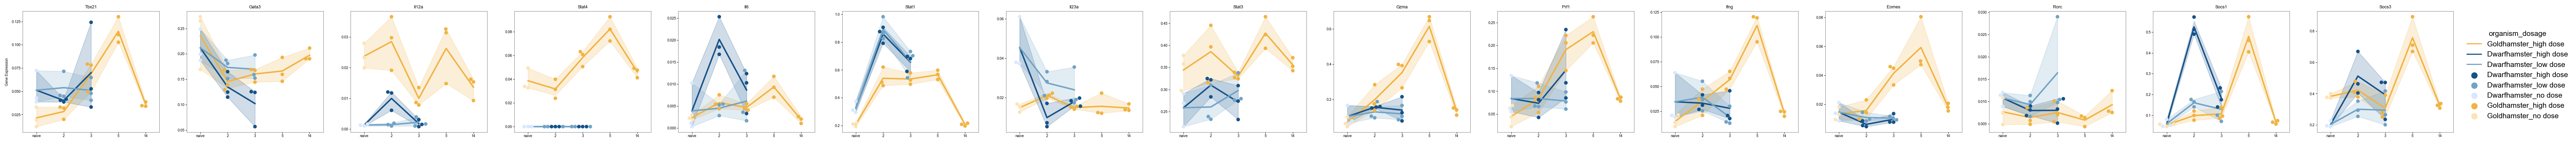

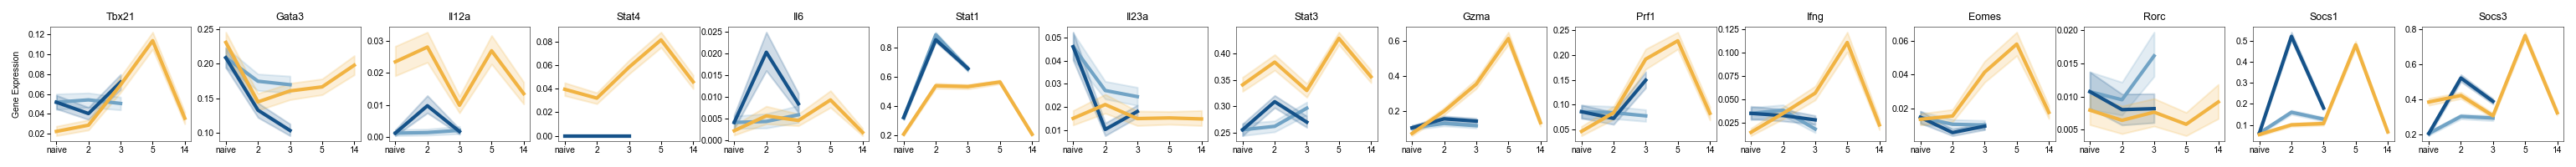

In [13]:
axs = plot_timecourse_dose_samples(superdata, markers, ci=95)
pl.savefig('Timecourse_all_samplewise.pdf', bbox_inches='tight', dpi=300)
axs = plot_timecourse_dose(superdata, markers, ci=99, markers=True, linewidth=2, palette=palette)
for ax in axs:
    ax.get_legend().remove()
pl.savefig('Timecourse_all_cellwise.pdf', bbox_inches='tight', dpi=300)


# Extra analysis

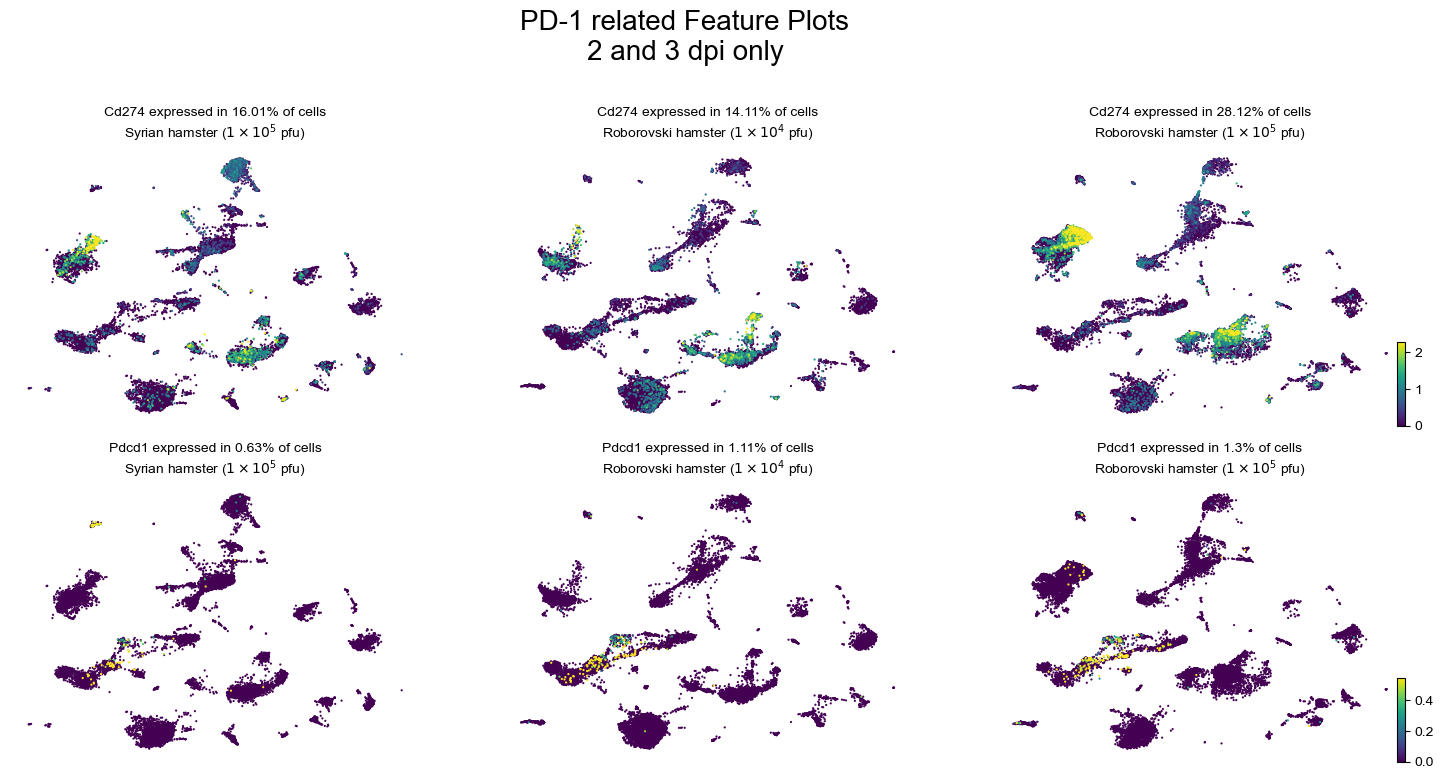

In [56]:
keys = ['Cd274', 'Pdcd1']
N = len(keys)
fig, axss = pl.subplots(N, 3, figsize=(6*3, 4*N))
kwargs = dict(dpi=80, legend_loc='right margin', show=False, s=10)  # perc=[0.5,99.5], 

for key, axs in zip(keys, axss):
    vmax = np.percentile(superdata[superdata.obs.time.isin(['D2', 'D3']), key].X.A, 99.5)
    for ax, organism, dosage in zip(axs, ['Goldhamster', 'Dwarfhamster', 'Dwarfhamster'], ['high dose', 'low dose', 'high dose']):
        mask = (superdata.obs.organism==organism) & (superdata.obs.dosage.isin(['no dose', dosage])) & (superdata.obs.time.isin(['D2', 'D3']))
        perc_exp = np.sum(superdata[mask, key].X!=0) / np.sum(mask)
        scv.pl.scatter(superdata[mask], 
                       basis='umap_scVI',
                       color=key, ax=ax, 
                       title=f'{key} expressed in {np.round(perc_exp*100,2)}% of cells\n{sanitize_name(organism)} ({sanitize_name(dosage)})',
                       vmin=0, vmax=vmax,
                       colorbar=ax==axs[-1],
                       **kwargs)
pl.suptitle('PD-1 related Feature Plots\n2 and 3 dpi only', fontsize=20, y=1.05)
# pl.savefig(figure_path / 'Fig3_selected_Immunity_umaps.pdf', bbox_inches='tight', dpi=300)
# pl.savefig(figure_path / 'Fig3_selected_Immunity_umaps.png', bbox_inches='tight', dpi=300)
pl.show()

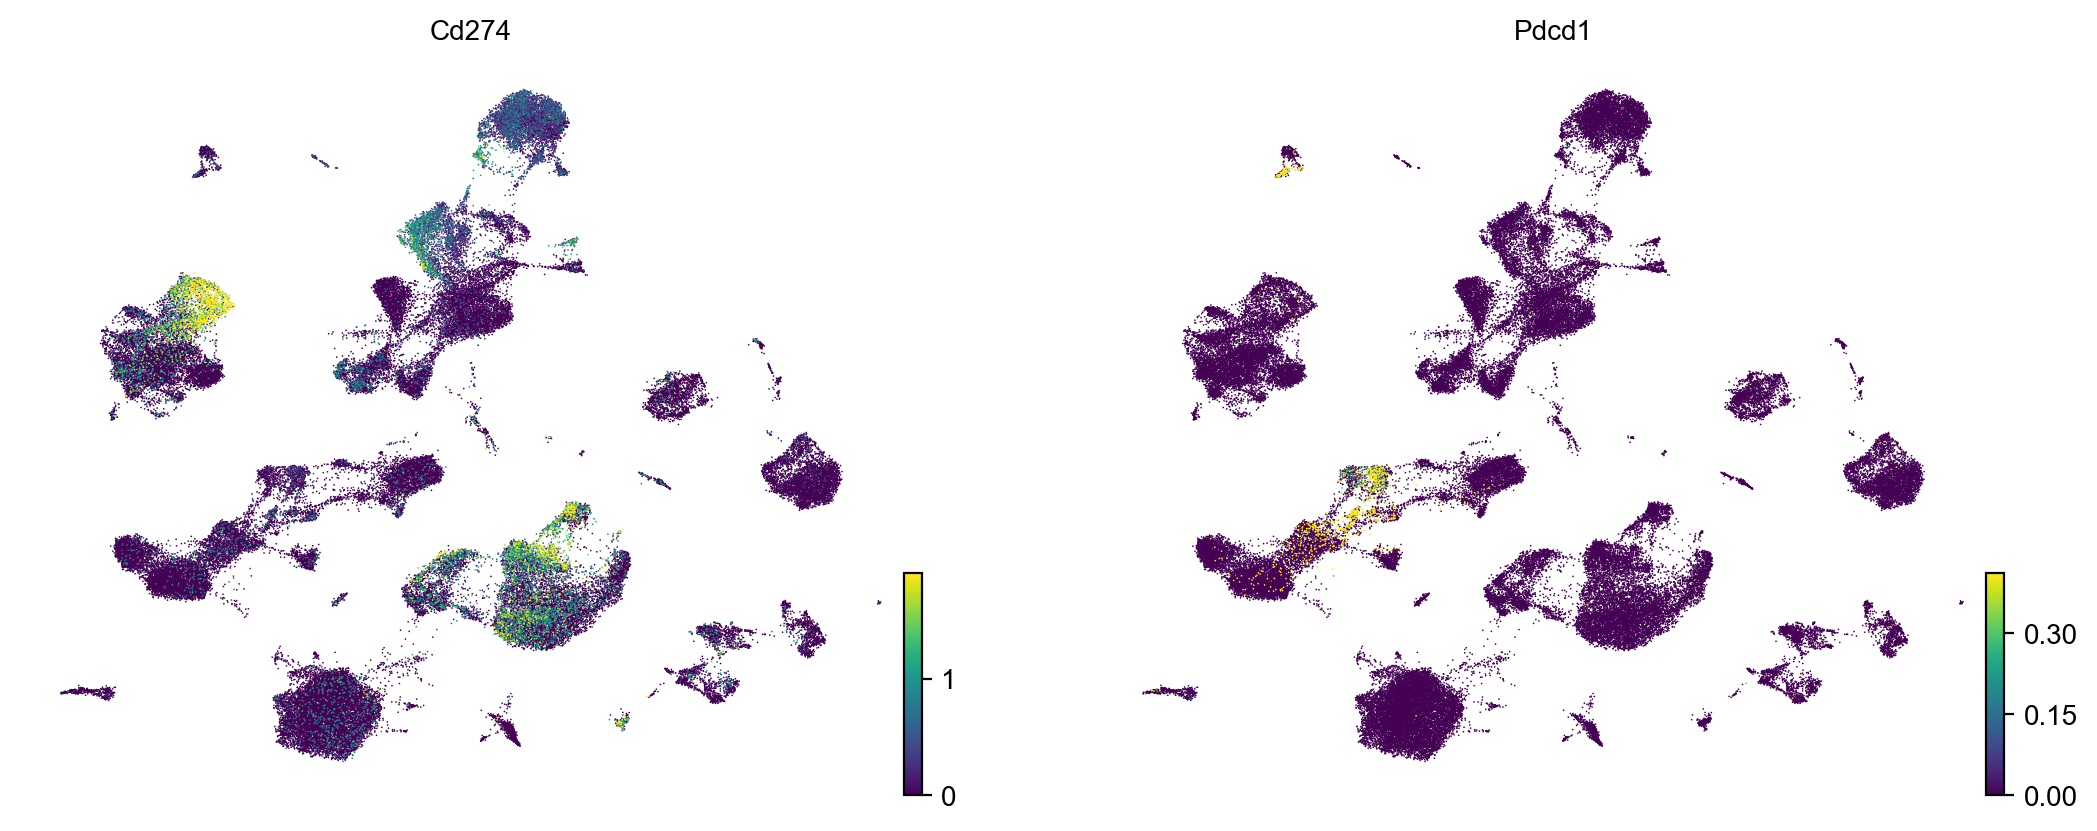

In [54]:
scv.pl.scatter(superdata, basis='umap_scVI', color=['Cd274', 'Pdcd1'], perc=[1, 99], dpi=200)

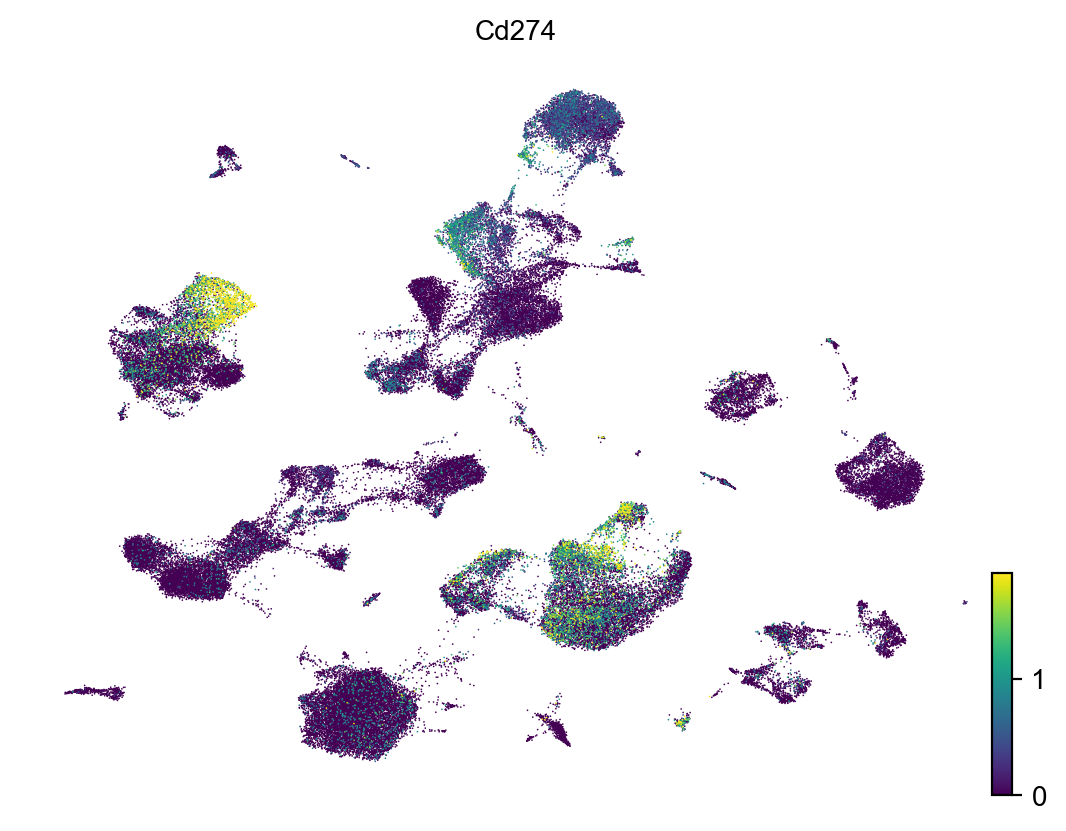

In [10]:
scv.pl.scatter(superdata, basis='umap_scVI', color='Cd274', perc=[1, 99], dpi=200)

[<Axes: ylabel='Pdcd1'>, <Axes: ylabel='Cd274'>]

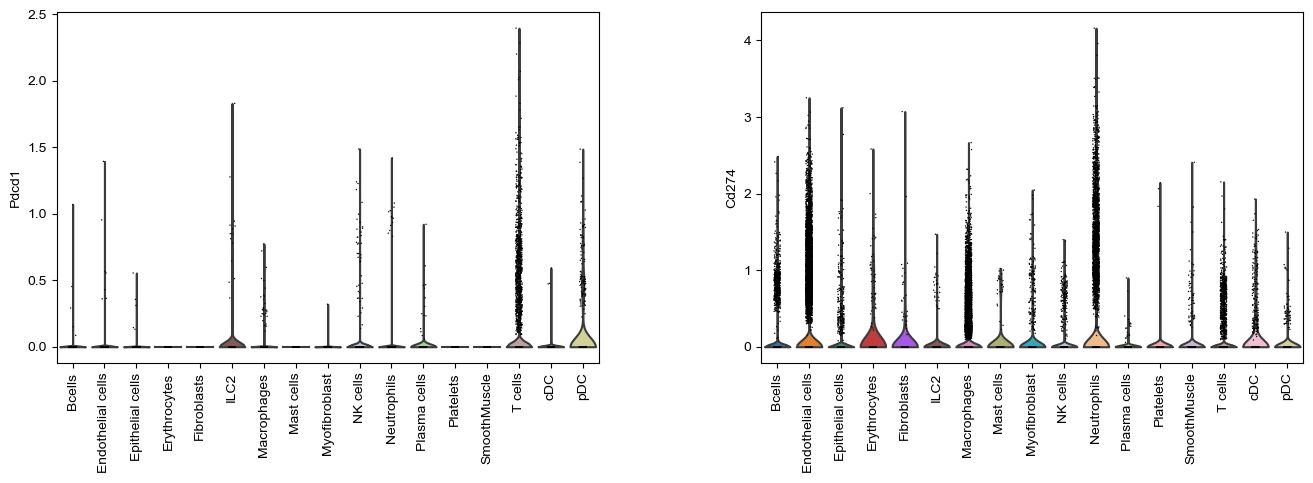

In [15]:
sc.pl.violin(superdata, ['Pdcd1', 'Cd274'], groupby='celltype_rough', show=False, dpi=200, rotation=90)

In [4]:
df = superdata.obs.copy()
df['Cd274'] = superdata[:, 'Cd274'].X.A
df['Pdcd1'] = superdata[:, 'Pdcd1'].X.A
df['Cd274+'] = superdata[:, 'Cd274'].X.A>0
df['Pdcd1+'] = superdata[:, 'Pdcd1'].X.A>0
sdf = df[df.celltype_rough.isin(['NK cells', 'T cells', 'ILC2', 'Epithelial cells'])]
sdf.celltype_rough = sdf.celltype_rough.astype(str)

In [44]:
sdf[(sdf.time=='D2') & (sdf.dosage!='low dose')].value_counts(['celltype_rough', 'organism', 'Pdcd1+'], sort=False)

celltype_rough    organism      Pdcd1+
Epithelial cells  Dwarfhamster  False     370
                                True        2
                  Goldhamster   False     719
ILC2              Dwarfhamster  False      31
                                True        3
                  Goldhamster   False      94
                                True        1
NK cells          Dwarfhamster  False     273
                                True        8
                  Goldhamster   False     183
                                True        2
T cells           Dwarfhamster  False     451
                                True       89
                  Goldhamster   False     771
                                True       21
dtype: int64

<AxesSubplot: xlabel='Pdcd1', ylabel='celltype_rough'>

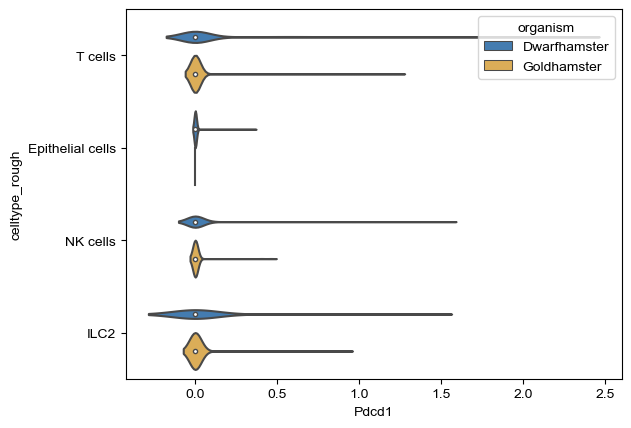

In [37]:
sns.violinplot(data=sdf[(sdf.time=='D2') & (sdf.dosage!='low dose')], y='celltype_rough', x='Pdcd1', palette=organism_colors, hue='organism')

In [3]:
palette = {'Goldhamster': organism_colors['Goldhamster'],
           'Dwarfhamster_low dose': organism_dosage_colors['Dwarfhamster_low dose'],
           'Dwarfhamster_high dose': organism_dosage_colors['Dwarfhamster_high dose'],
}

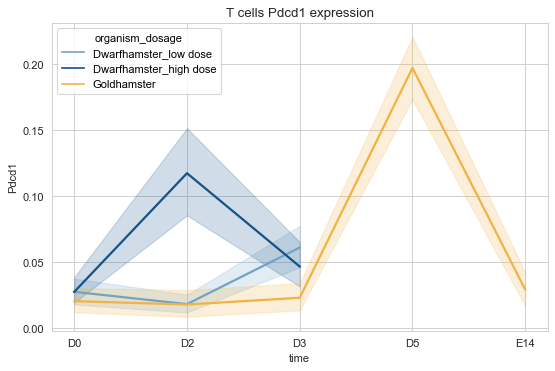

In [7]:
axs = plot_timecourse_dose(superdata[superdata.obs.celltype_rough=='T cells'], ['Pdcd1'], x='time', 
                     ci=99, markers=True, linewidth=2, palette=palette)
pl.title('T cells Pdcd1 expression')
pl.savefig(figure_path / 'Tcells_Pdcd1_timecourse.pdf', bbox_inches='tight', dpi=300)
pl.show()

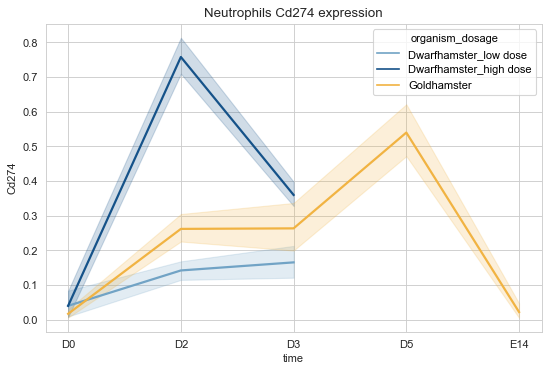

In [8]:
axs = plot_timecourse_dose(superdata[superdata.obs.celltype_rough=='Neutrophils'], ['Cd274'], x='time', 
                     ci=99, markers=True, linewidth=2, palette=palette)
pl.title('Neutrophils Cd274 expression')
pl.savefig(figure_path / 'Neutrophils_Cd274_timecourse.pdf', bbox_inches='tight', dpi=300)
pl.show()

In [35]:
cdf = df[df.celltype_rough.isin(['T cells', 'NK cells', 'Neutrophils'])].value_counts(['organism', 'time', 'dosage', 'replicate', 'celltype_rough', 'Pdcd1+'], sort=False, dropna=False)

In [36]:
freq = cdf / df[df.celltype_rough.isin(['T cells', 'NK cells', 'Neutrophils'])].value_counts(['organism', 'time', 'dosage', 'replicate', 'celltype_rough'], sort=False, dropna=False)

In [37]:
freq.to_csv('Pdcd1_freq.csv')
cdf.to_csv('Pdcd1_cell_counts.csv')

In [31]:
cdf

organism      time  dosage     replicate  celltype_rough  Pdcd1+
Dwarfhamster  D0    no dose    1          NK cells        False     175
                                          Neutrophils     False      87
                                          T cells         False     478
                                                          True       18
                               2          NK cells        False      88
                                                                   ... 
Goldhamster   E14   high dose  2          T cells         True       13
                               3          NK cells        False      80
                                          Neutrophils     False     241
                                          T cells         False     244
                                                          True       11
Length: 144, dtype: int64

In [33]:
freq

organism      time  dosage     replicate  celltype_rough  Pdcd1+
Dwarfhamster  D0    no dose    1          NK cells        False     1.000000
                                          Neutrophils     False     1.000000
                                          T cells         False     0.963710
                                                          True      0.036290
                               2          NK cells        False     1.000000
                                                                      ...   
Goldhamster   E14   high dose  2          T cells         True      0.034392
                               3          NK cells        False     1.000000
                                          Neutrophils     False     1.000000
                                          T cells         False     0.956863
                                                          True      0.043137
Length: 144, dtype: float64